In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms   # demo dataset + preprocessing
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

2. Define the network

+ nn.Sequential stitches the layers together in order.
+ Each hidden layer is Linear → ReLU (→ Dropout).
+ No softmax in forward; we’ll apply it in the loss (CrossEntropyLoss expects raw logits).

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list[int], output_dim: int,
                 dropout_p: float = 0.0):
        """
        input_dim   - total number of input features (e.g. 28×28 = 784 for MNIST)
        hidden_dims - list like [256, 128] → two hidden layers with those sizes
        output_dim  - number of output units (10 for MNIST digits 0‑9)
        dropout_p   - dropout probability (0 → no dropout)
        """
        super().__init__()

        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            # add hidden layer
            layers += [
                nn.Linear(prev_dim, h),
                nn.ReLU(),
            ]
            # add dropout layer if dropout_p > 0
            if dropout_p > 0:
                layers.append(nn.Dropout(dropout_p))
            prev_dim = h
        # add final layer
        layers.append(nn.Linear(prev_dim, output_dim))  # output layer
        print(f"layers sizes: {layers.__len__()}")
        print(f"layers: {layers}")
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x comes in with shape [batch_size, input_dim]
        return self.model(x)


3 . Prepare data (MNIST demo)

train_set length: 60000
train_set data shape: torch.Size([60000, 28, 28])
test_set data shape: torch.Size([10000, 28, 28])
train_set targets shape: torch.Size([60000])
test_set targets shape: torch.Size([10000])


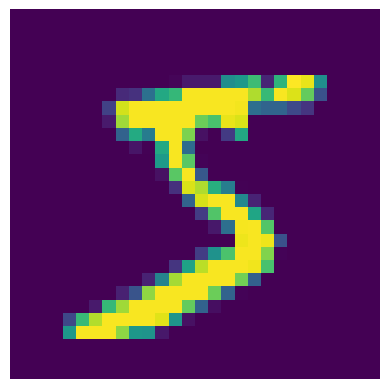

Print first row label: 5
train_loader shape: 60000
test_loader shape: 10000


In [ ]:
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.ToTensor(),               # converts H×W×C in [0,1]
    transforms.Lambda(lambda x: x.view(-1))  # flatten to 784‑vector
])

train_set = datasets.MNIST(root="data", train=True,  download=True, transform=transform)
test_set  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(f"train_set data shape: {train_set.data.shape}")
print(f"test_set data shape: {test_set.data.shape}")

print(f"train_set targets shape: {train_set.targets.shape}")
print(f"test_set targets shape: {test_set.targets.shape}")

# Display the image
plt.imshow(train_set.data[0])
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
print(f"Print first row label: {train_set.targets[0]}")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE)

print(f"train_loader shape: {len(train_loader.dataset.data)}")
print(f"test_loader shape: {len(test_loader.dataset.data)}")


4 . Instantiate network, loss, optimizer

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

mlp_model = MLP(input_dim=784, hidden_dims=[256, 128], output_dim=10, dropout_p=0.2).to(DEVICE)
criterion = nn.CrossEntropyLoss()                 # handles logits + integer labels
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3) # any torch optimizer works

layers sizes: 7
layers: [Linear(in_features=784, out_features=256, bias=True), ReLU(), Dropout(p=0.2, inplace=False), Linear(in_features=256, out_features=128, bias=True), ReLU(), Dropout(p=0.2, inplace=False), Linear(in_features=128, out_features=10, bias=True)]


5 . Training loop

In [ ]:
EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    mlp_model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        # optimizer.zero_grad() - clear gradients from previous step
        optimizer.zero_grad()
        # mlp_model(X) - forward pass
        logits = mlp_model(X)  # forward
        # criterion(logits, y) - compute loss
        loss = criterion(logits, y)
        # loss.backward() - compute gradients
        loss.backward()   # backward
        # optimizer.step() - update weights
        optimizer.step()  # update weights
        # running_loss += loss.item() * X.size(0) - accumulate loss
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch:2d}/{EPOCHS} - train loss: {epoch_loss:.4f}")


Epoch  1/5 - train loss: 0.3882
Epoch  2/5 - train loss: 0.1538
Epoch  3/5 - train loss: 0.1095
Epoch  4/5 - train loss: 0.0867
Epoch  5/5 - train loss: 0.0710


6 . Evaluation helper

In [7]:
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    return correct / total


In [ ]:
test_acc = evaluate(mlp_model, test_loader)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 97.90%


7 . Inference on new data

In [ ]:
mlp_model.eval()
with torch.no_grad():
    sample, _ = test_set[0]             # first image, ignore label here
    sample = sample.to(DEVICE)
    pred_digit = mlp_model(sample).argmax().item()
print("Predicted digit:", pred_digit)

Predicted digit: 7
